In [1]:
import pandas as pd

X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'],
                  'ordinal_column':['somewhat like', 'like',
                  'somewhat like', 'like', 'somewhat like', 'dislike'],'quantitative_column':[1, 11, -.5, 10, None,20]})

In [2]:
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [3]:
X['city'].value_counts()

tokyo            2
seattle          1
london           1
san francisco    1
Name: city, dtype: int64

In [4]:
X['city'].fillna(X['city'].value_counts().index[0],inplace=True)
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [5]:
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self,cols=None):
        self.cols = cols
    def transform(self,df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    def fit(self, *_):
        return self
            

In [6]:
cci = CustomCategoryImputer(cols=['city','boolean'])
cci.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [7]:
from sklearn.preprocessing import Imputer
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    def fit(self, *_):
        return self

In [8]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'],strategy='mean')
cqi.fit_transform(X)


,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [9]:
# import Pipeline from sklearn
from sklearn.pipeline import Pipeline

imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [10]:
pd.get_dummies(X,columns=['city','boolean'],prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,1,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [11]:
# create our custom dummifier
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    def fit(self, *_):
        return self

In [12]:
cd = CustomDummifier(cols=['boolean', 'city'])

cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,1
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


In [13]:
ordering = ['dislike', 'somewhat like', 'like'] 

In [14]:
X['ordinal_column']

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object

In [15]:
for x in ordering:
    print(x.index)

<built-in method index of str object at 0x000002537F0EBC70>
<built-in method index of str object at 0x000002530EE2A9F0>
<built-in method index of str object at 0x000002537F9C71B8>


In [16]:
X['ordinal_column'].map(lambda x:ordering.index(x))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64

In [17]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    def fit(self, *_):
        return self

In [18]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,1,1.0
1,no,tokyo,2,11.0
2,None,london,1,-0.5
3,no,seattle,2,10.0
4,no,san francisco,1,NaN
5,yes,tokyo,0,20.0


In [19]:
pd.cut(X['quantitative_column'],bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [20]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins,labels=self.labels)
        return X
    def fit(self, *_):
        return self

In [21]:
cc = CustomCutter(col='quantitative_column', bins=3)
cc.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,0.0
1,no,tokyo,like,1.0
2,None,london,somewhat like,0.0
3,no,seattle,like,1.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,2.0


In [22]:
pipe = Pipeline([("imputer", imputer), ('dummify', cd), ('encode', ce),('cut', cc)])
# will use our initial imputer
# will dummify variables first
# then encode the ordinal column
# then bucket (bin) the quantitative column

In [23]:
pipe.fit(X)

Pipeline(memory=None,
     steps=[('imputer', Pipeline(memory=None,
     steps=[('quant', <__main__.CustomQuantitativeImputer object at 0x000002530E3158D0>), ('category', <__main__.CustomCategoryImputer object at 0x000002530E3151D0>)])), ('dummify', <__main__.CustomDummifier object at 0x000002530EE53898>), ('encode', <__main__.CustomEncoder object at 0x000002530EE664A8>), ('cut', <__main__.CustomCutter object at 0x000002530EE53048>)])

In [24]:
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


# Encoding numerical

In [25]:
df = pd.read_csv('data/activity_recog.csv')

In [26]:
df.head()

,0,1502,2215,2153,1
0,1.0,1667,2072,2047,1
1,2.0,1611,1957,1906,1
2,3.0,1601,1939,1831,1
3,4.0,1643,1965,1879,1
4,5.0,1604,1959,1921,1


In [27]:
df.columns = ['index','x','y','z','activity']

In [28]:
df.head()

,index,x,y,z,activity
0,1.0,1667,2072,2047,1
1,2.0,1611,1957,1906,1
2,3.0,1601,1939,1831,1
3,4.0,1643,1965,1879,1
4,5.0,1604,1959,1921,1


In [29]:
df['activity'].value_counts(normalize=True)

7    0.515372
1    0.207237
4    0.165292
3    0.068794
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [31]:
X = df[['x', 'y', 'z']]
# create our feature matrix by removing the response variable
y = df['activity']

In [32]:
knn_params = {'n_neighbors':[3, 4, 5, 6]}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,knn_params)
grid.fit(X,y)

C:\Users\richard\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [33]:
print(grid.best_score_, grid.best_params_)

0.7205230769230769 {'n_neighbors': 5}


In [34]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)

In [35]:
X_poly = poly.fit_transform(X)
X_poly.shape

(162500, 9)

In [36]:
pd.DataFrame(X_poly,columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
1,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
2,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
3,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0
4,1604.0,1959.0,1921.0,2572816.0,3142236.0,3081284.0,3837681.0,3763239.0,3690241.0


In [37]:
%matplotlib inline
import seaborn as sns

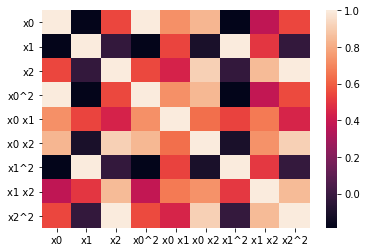

In [38]:
sns.heatmap(pd.DataFrame(X_poly,columns=poly.get_feature_names()).corr())

In [39]:
poly = PolynomialFeatures(degree=2, include_bias=False,interaction_only=True) 
X_poly = poly.fit_transform(X) 
print (X_poly.shape)

(162500, 6)


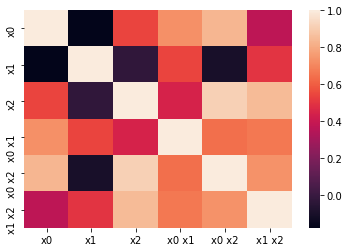

In [40]:
sns.heatmap(pd.DataFrame(X_poly,columns=poly.get_feature_names()).corr())

In [41]:
pipe_params = {'poly_features__degree':[1, 2, 3],
'poly_features__interaction_only':[True, False],
'classify__n_neighbors':[3, 4, 5, 6]}


In [42]:
pipe = Pipeline([('poly_features', poly), ('classify', knn)])


In [43]:
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)


C:\Users\richard\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.7207323076923077 {'classify__n_neighbors': 5, 'poly_features__degree': 3, 'poly_features__interaction_only': False}


# Text-specific feature construction


In [44]:
tweets = pd.read_csv('data/twitter_sentiment.csv',encoding='latin1')

In [45]:
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [46]:
del tweets['ItemID']

In [47]:
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [48]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [49]:
X = tweets['SentimentText']
y = tweets['Sentiment']


In [50]:
vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105849)


In [51]:
_

<99989x105849 sparse matrix of type '<class 'numpy.int64'>'
	with 1191479 stored elements in Compressed Sparse Row format>

In [52]:
y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

In [53]:
from sklearn.naive_bayes import MultinomialNB # for faster predictions with
# set our pipeline parameters
pipe_params = {'vect__ngram_range':[(1, 1), (1, 2)],
'vect__max_features':[1000, 10000], 'vect__stop_words':[None, 'english']}
# instantiate our pipeline
pipe = Pipeline([('vect', CountVectorizer()), ('classify',MultinomialNB())])

 # instantiate our gridsearch object
grid = GridSearchCV(pipe, pipe_params)
# fit the gridsearch object
grid.fit(X, y)
# get our results
print(grid.best_score_, grid.best_params_)


0.7557531328446129 {'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}


In [54]:
from sklearn.pipeline import FeatureUnion
# build a separate featurizer object
featurizer = FeatureUnion([('tfidf_vect', TfidfVectorizer()),('count_vect', CountVectorizer())])

In [55]:
_ = featurizer.fit_transform(X)
print( _.shape) # same number of rows , but twice as many columns as eitherCV or TFIDF

(99989, 211698)


In [56]:
featurizer.set_params(tfidf_vect__max_features=100,count_vect__ngram_range=(1, 2),count_vect__max_features=300)

FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smo...   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None))],
       transformer_weights=None)

In [57]:
pipe_params = {'featurizer__count_vect__ngram_range':[(1, 1), (1, 2)],'featurizer__count_vect__max_features':[1000, 10000],
                'featurizer__count_vect__stop_words':[None, 'english'],
                'featurizer__tfidf_vect__ngram_range':[(1, 1), (1, 2)],
               'featurizer__tfidf_vect__max_features':[1000, 10000],
               'featurizer__tfidf_vect__stop_words':[None, 'english']}
pipe = Pipeline([('featurizer', featurizer), ('classify',MultinomialNB())])
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)
print (grid.best_score_, grid.best_params_)

0.7584334276770445 {'featurizer__count_vect__max_features': 10000, 'featurizer__count_vect__ngram_range': (1, 2), 'featurizer__count_vect__stop_words': None, 'featurizer__tfidf_vect__max_features': 10000, 'featurizer__tfidf_vect__ngram_range': (1, 1), 'featurizer__tfidf_vect__stop_words': 'english'}
